In [3]:
import intake

import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

In [4]:
pancontrol01 = intake.open_esm_datastore('/home/272/kc5856/panantrial/experiment_datastore.json', columns_with_iterables=['variable'])
pantrial01 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/experiment_datastore.json', columns_with_iterables=['variable'])

In [3]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37519,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:42911,Total threads: 1
Dashboard: /proxy/34421/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:37785,


In [38]:
#Time variant variables #ASK HOW TO CONDENSE
control_WFO = pancontrol01.search(variable="wfo", frequency="1mon").to_dask()
trial_WFO = pantrial01.search(variable="wfo", frequency="1mon").to_dask()
control_TOB = pancontrol01.search(variable="tob", frequency="1mon").to_dask()
trial_TOB = pantrial01.search(variable="tob", frequency="1mon").to_dask()
control_temp = pancontrol01.search(variable="thetao", frequency="1mon").to_dask()
trial_temp = pantrial01.search(variable="thetao", frequency="1mon").to_dask()

In [37]:
#Area weighting
data_fixed = pancontrol01.search(variable=["areacello","deptho"],path=".*output021.*").to_dask()

In [39]:
areacello = data_fixed.areacello
control_WFO = control_WFO.assign_coords({"areacello": areacello})
trial_WFO = trial_WFO.assign_coords({"areacello": areacello})
control_TOB = control_TOB.assign_coords({"areacello": areacello})
trial_TOB = trial_TOB.assign_coords({"areacello": areacello})
control_temp = control_temp.assign_coords({"areacello": areacello})
trial_temp = trial_temp.assign_coords({"areacello": areacello})

In [7]:
WFOpert = trial_WFO.wfo.sel(time=slice('2001-01','2010-01')).mean(dim='time')
WFOcont = control_WFO.wfo.sel(time=slice('2001-01','2010-01')).mean(dim='time')
WFOanom = WFOpert - WFOcont

In [42]:
TOBpert = trial_TOB.tob.sel(time=slice('2001-01','2010-01')).mean(dim='time')
TOBcont = control_TOB.tob.sel(time=slice('2001-01','2010-01')).mean(dim='time')
TOBanom = TOBpert - TOBcont

temppert = trial_temp.thetao.sel(time=slice('2001-01','2010-01')).mean(dim='time')
tempcont = control_temp.thetao.sel(time=slice('2001-01','2010-01')).mean(dim='time')
tempanom = temppert - tempcont

In [43]:
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

In [44]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",     
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [45]:
depth = data_fixed.deptho#.to_array().squeeze()
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

(-80.0, -65.0)

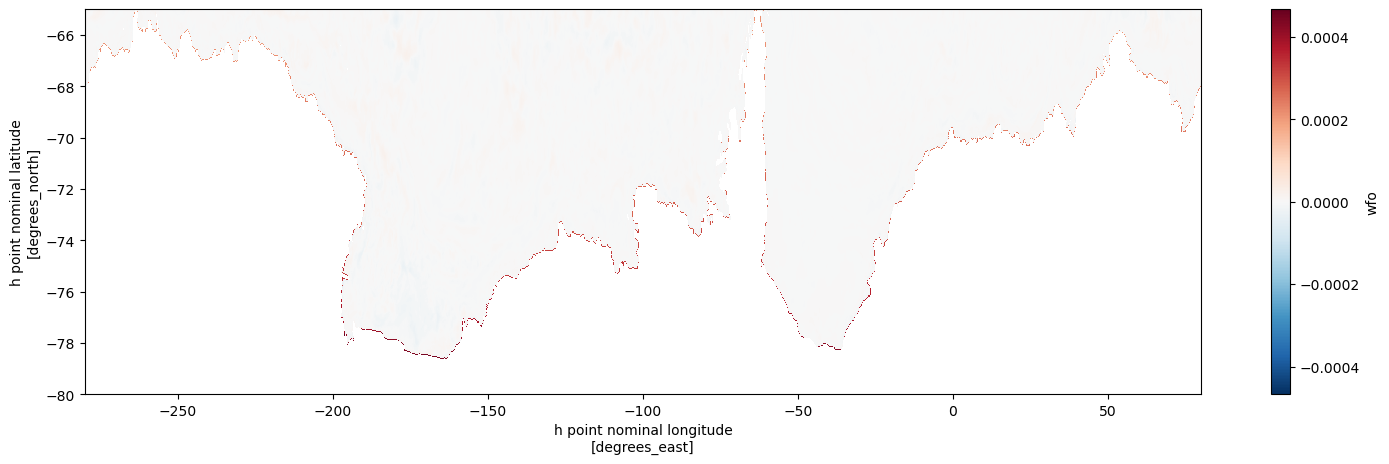

In [19]:
plt.figure(figsize=(18, 5))
WFOanom.plot()
plt.ylim(-80,-65)

(-73.0, -71.0)

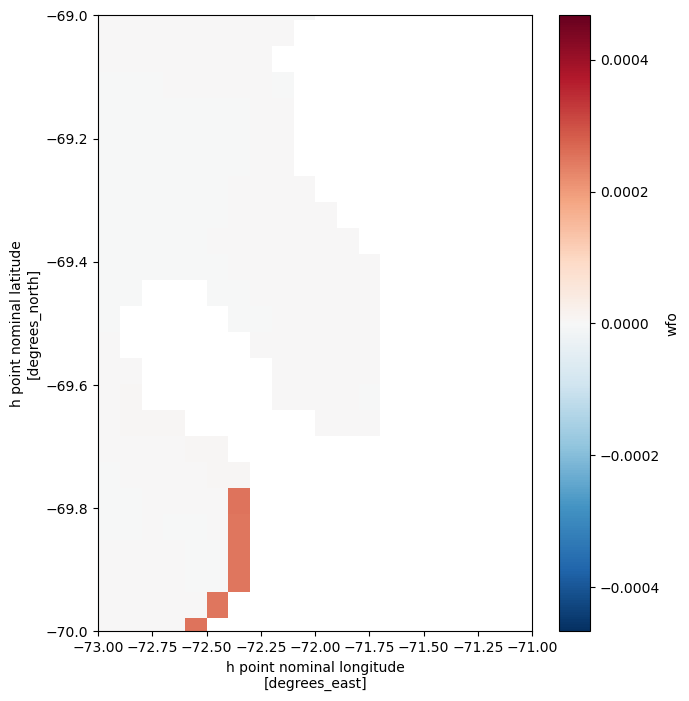

In [34]:
plt.figure(figsize=(7, 8))
WFOanom.plot()
plt.ylim(-70,-69)
plt.xlim(-73,-71)

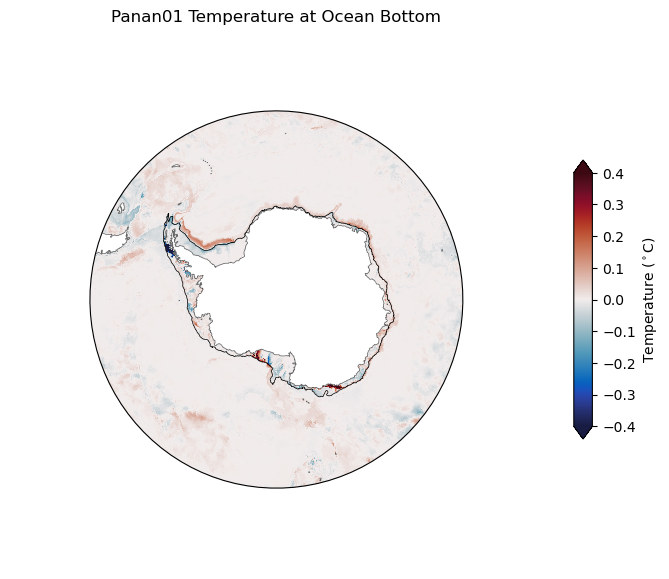

In [49]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.35
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'black', linewidths=0.5,transform = ccrs.PlateCarree())

SOanom_TOB.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.4,
    vmax=0.4,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Temperature ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Panan01 Temperature at Ocean Bottom");

In [46]:
tempcont_top_time = control_temp.thetao.sel(time=slice('2001-01','2010-01')).isel(z_l=0).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
tempcont_mid_time = control_temp.thetao.sel(time=slice('2001-01','2010-01')).sel(z_l='500', method='nearest').weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
tempcont_bot_time = control_TOB.tob.sel(time=slice('2001-01','2010-01')).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))

temppert_top_time = trial_temp.thetao.sel(time=slice('2001-01','2010-01')).isel(z_l=0).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
temppert_mid_time = trial_temp.thetao.sel(time=slice('2001-01','2010-01')).sel(z_l='500', method='nearest').weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
temppert_bot_time = trial_TOB.tob.sel(time=slice('2001-01','2010-01')).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))

In [47]:
tempanom_top_time = temppert_top_time - tempcont_top_time
tempanom_mid_time = temppert_mid_time - tempcont_mid_time
tempanom_bot_time = temppert_bot_time - tempcont_bot_time

Text(0.5, 1.0, 'Time Series of Temperature at Ocean Surface')

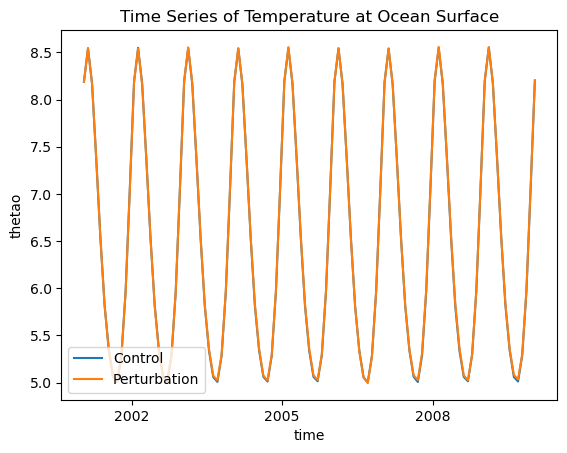

In [49]:
tempcont_top_time.plot(label="Control")
temppert_top_time.plot(label="Perturbation")
plt.legend(loc="lower left")
plt.title("Time Series of Temperature at Ocean Surface")

Text(0.5, 1.0, 'Time Series of Temperature at 500 m Depth')

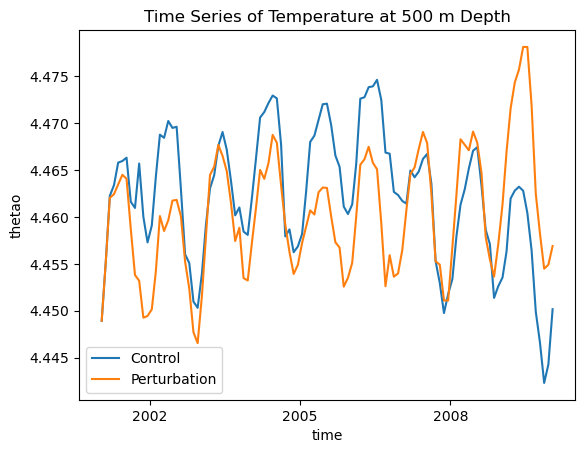

In [51]:
tempcont_mid_time.plot(label="Control")
temppert_mid_time.plot(label="Perturbation")
plt.legend(loc="lower left")
plt.title("Time Series of Temperature at 500 m Depth")

Text(0.5, 1.0, 'Time Series of Temperature at Ocean Floor')

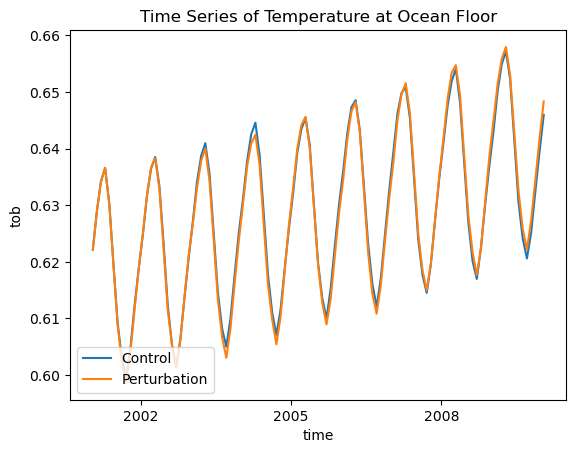

In [52]:
tempcont_bot_time.plot(label="Control")
temppert_bot_time.plot(label="Perturbation")
plt.legend(loc="lower left")
plt.title("Time Series of Temperature at Ocean Floor")

In [53]:
tempcont_top_shelf = control_temp.thetao.where(shelf_mask == 1).sel(time=slice('2001-01','2010-01')).isel(z_l=0).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
tempcont_mid_shelf = control_temp.thetao.where(shelf_mask == 1).sel(time=slice('2001-01','2010-01')).sel(z_l='500', method='nearest').weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
tempcont_bot_shelf = control_TOB.tob.where(shelf_mask == 1).sel(time=slice('2001-01','2010-01')).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))

temppert_top_shelf = trial_temp.thetao.where(shelf_mask == 1).sel(time=slice('2001-01','2010-01')).isel(z_l=0).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
temppert_mid_shelf = trial_temp.thetao.where(shelf_mask == 1).sel(time=slice('2001-01','2010-01')).sel(z_l='500', method='nearest').weighted(areacello.fillna(0)).mean(dim=('xh','yh'))
temppert_bot_shelf = trial_TOB.tob.where(shelf_mask == 1).sel(time=slice('2001-01','2010-01')).weighted(areacello.fillna(0)).mean(dim=('xh','yh'))

tempanom_top_shelf = temppert_top_shelf - tempcont_top_shelf
tempanom_mid_shelf = temppert_mid_shelf - tempcont_mid_shelf
tempanom_bot_shelf = temppert_bot_shelf - tempcont_bot_shelf

Text(0.5, 1.0, 'Time Series of Shelf Temperature at Ocean Surface')

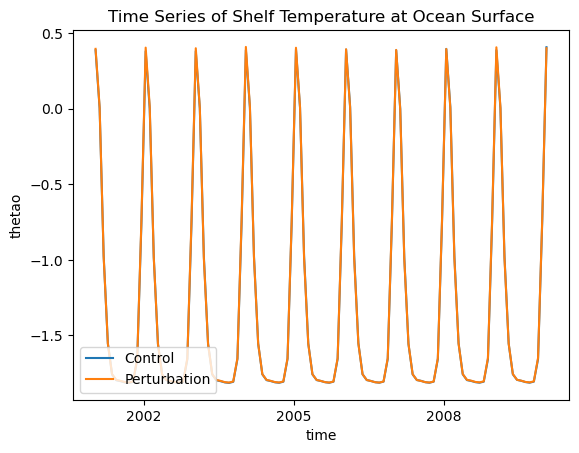

In [54]:
tempcont_top_shelf.plot(label="Control")
temppert_top_shelf.plot(label="Perturbation")
plt.legend(loc="lower left")
plt.title("Time Series of Shelf Temperature at Ocean Surface")

Text(0.5, 1.0, 'Time Series of Shelf Temperature at 500 m Depth')

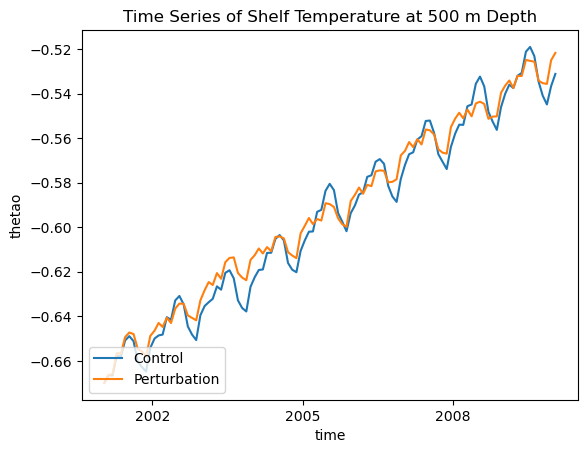

In [56]:
tempcont_mid_shelf.plot(label="Control")
temppert_mid_shelf.plot(label="Perturbation")
plt.legend(loc="lower left")
plt.title("Time Series of Shelf Temperature at 500 m Depth")

Text(0.5, 1.0, 'Time Series of Shelf Temperature at Ocean Floor')

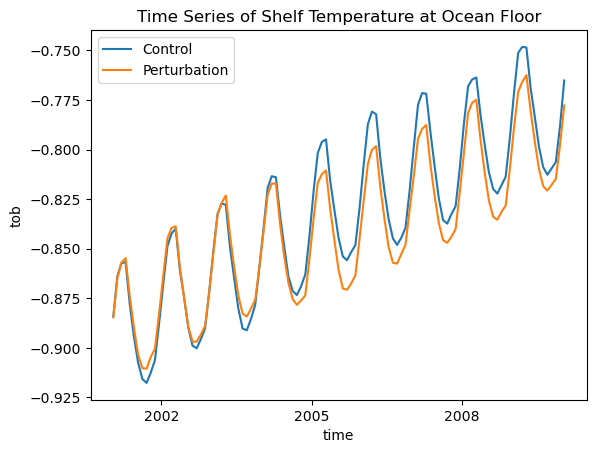

In [58]:
tempcont_bot_shelf.plot(label="Control")
temppert_bot_shelf.plot(label="Perturbation")
plt.legend(loc="upper left")
plt.title("Time Series of Shelf Temperature at Ocean Floor")

In [25]:
variables = pancontrol01.unique().variable
print(variables)

['xT', 'xTe', 'yT', 'yTe', 'time', 'nv', 'siconc', 'sithick', 'average_T1', 'average_T2', 'average_DT', 'time_bnds', 'xh', 'yh', 'xq', 'yq', 'zos', 'tob', 'sob', 'mlotst', 'umo_2d', 'vmo_2d', 'tauuo', 'tauvo', 'hfds', 'wfo', 'fsitherm', 'salt_flux', 'salt_flux_added', 'rho2_l', 'rho2_i', 'volcello', 'umo', 'vmo', 'z_l', 'z_i', 'uo', 'vo', 'thetao', 'so', 'rhopot2', 'rhopot0', 'agessc', 'areacello', 'deptho', 'Coriolis', 'geolon', 'geolat', 'geolon_c', 'geolat_c', 'geolon_u', 'geolat_u', 'geolon_v', 'geolat_v', 'wet', 'wet_c', 'wet_u', 'wet_v', 'dxt', 'dyt', 'dxCu', 'dyCu', 'dxCv', 'dyCv', 'areacello_cu', 'areacello_cv', 'areacello_bu', 'net_melt', 'xB', 'yB', 'IX_TRANS', 'IY_TRANS', 'zl', 'T_adx_2d', 'T_ady_2d', 'z_l_sub01', 'precip', 'lrunoff', 'Kd_interface', 'T_adx', 'T_ady', 'Kd_heat', 'Kd_salt', 'Kd_ePBL', 'Kd_shear', 'Kd_BBL', 'dudt', 'dvdt', 'CAu', 'CAv', 'rvxv', 'rvxu', 'gKEu', 'gKEv', 'PFu', 'PFv', 'u_BT_accel', 'v_BT_accel', 'diffu', 'diffv', 'du_dt_visc', 'dv_dt_visc', 'taux

In [8]:
variables = pancontrol01.unique().variable
print(variables)

['xT', 'xTe', 'yT', 'yTe', 'time', 'nv', 'siconc', 'sithick', 'average_T1', 'average_T2', 'average_DT', 'time_bnds', 'xh', 'yh', 'xq', 'yq', 'zos', 'tob', 'sob', 'mlotst', 'umo_2d', 'vmo_2d', 'tauuo', 'tauvo', 'hfds', 'wfo', 'fsitherm', 'salt_flux', 'salt_flux_added', 'rho2_l', 'rho2_i', 'volcello', 'umo', 'vmo', 'z_l', 'z_i', 'uo', 'vo', 'thetao', 'so', 'rhopot2', 'rhopot0', 'agessc', 'areacello', 'deptho', 'Coriolis', 'geolon', 'geolat', 'geolon_c', 'geolat_c', 'geolon_u', 'geolat_u', 'geolon_v', 'geolat_v', 'wet', 'wet_c', 'wet_u', 'wet_v', 'dxt', 'dyt', 'dxCu', 'dyCu', 'dxCv', 'dyCv', 'areacello_cu', 'areacello_cv', 'areacello_bu', 'net_melt', 'xB', 'yB', 'IX_TRANS', 'IY_TRANS', 'zl', 'T_adx_2d', 'T_ady_2d', 'z_l_sub01', 'precip', 'lrunoff', 'Kd_interface', 'T_adx', 'T_ady', 'Kd_heat', 'Kd_salt', 'Kd_ePBL', 'Kd_shear', 'Kd_BBL', 'dudt', 'dvdt', 'CAu', 'CAv', 'rvxv', 'rvxu', 'gKEu', 'gKEv', 'PFu', 'PFv', 'u_BT_accel', 'v_BT_accel', 'diffu', 'diffv', 'du_dt_visc', 'dv_dt_visc', 'taux